<a href="https://colab.research.google.com/github/Akobabs/Dilated-CNN-and-Attention-Mechanism-for-MonkeyPox/blob/main/TYPE_2_Grok(v1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimized Monkeypox Classification with Dilated CNN + Attention
## Refactored for Speed on Colab GPU (Retains Augmentation, Dilated CNN, Attention)

This notebook trains a ResNet-50 with dilated convolutions (rates 2/4/8) and CBAM-like attention for Mpox classification. Optimizations: AMP, gradient accumulation, torch.compile. Expected: 92-97% accuracy in 30-45 mins/epoch on T4 GPU.

In [1]:
# Install necessary libraries (run once)
!pip install -q albumentations seaborn scikit-learn

# Import libraries
import os
import sys
import zipfile
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Enable optimizations
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Mount Google Drive
Upload `monkeypox_dataset.zip` to `/MyDrive/` if needed.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Device Setup
Ensure GPU runtime: Runtime > Change runtime type > GPU (T4). This enables AMP for 2-3x speedup.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cpu':
    print("⚠️  WARNING: Using CPU - switch to GPU runtime for speed! Training will be slow.")
else:
    print("✅ GPU enabled - optimizations active.")

Using device: cuda
✅ GPU enabled - optimizations active.


## DatasetManager Class
Handles extraction, cleaning, and merging Healthy into Normal. Outputs distribution plot.

In [4]:
class DatasetManager:
    """Handles dataset extraction, cleaning, and preprocessing"""
    def __init__(self, zip_path, extract_to='./dataset'):
        self.zip_path = zip_path
        self.extract_to = Path(extract_to)
        self.base_path = None
        self.classes = ['Chickenpox', 'Cowpox', 'HFMD', 'Measles', 'Monkeypox', 'Normal']
        self.splits = ['train', 'val', 'test']

        if not os.path.exists(zip_path):
            raise FileNotFoundError(f"Zip file not found at: {zip_path}")

    def extract_and_setup(self):
        """Extract zip file and setup folder structure"""
        print("Extracting dataset...")

        # Clean up existing directory
        if self.extract_to.exists():
            shutil.rmtree(self.extract_to)

        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.extract_to)
        except Exception as e:
            raise Exception(f"Failed to extract zip file: {e}")

        # Find the correct dataset path
        possible_paths = [
            self.extract_to / 'monkeypox_dataset',
            self.extract_to / 'dataset' / 'monkeypox_dataset',
        ]

        # Also search for any folder containing relevant structure
        for item in self.extract_to.rglob('*'):
            if item.is_dir() and any(split in item.name.lower() for split in ['train', 'test', 'val']):
                possible_paths.append(item.parent)

        for path in possible_paths:
            if path and path.exists():
                train_path = path / 'train'
                if train_path.exists():
                    self.base_path = path
                    break

        if self.base_path is None:
            print("Extracted contents:")
            for item in self.extract_to.rglob('*'):
                print(f"  {item}")
            raise Exception("Could not find dataset with expected structure")

        print(f"Dataset extracted to: {self.base_path}")
        return self.clean_dataset()

    def clean_dataset(self):
        """Clean corrupt images and analyze distribution"""
        print("Cleaning dataset...")
        counts = {}
        corrupt_count = 0

        for split in self.splits:
            counts[split] = {}
            split_path = self.base_path / split

            if not split_path.exists():
                print(f"Warning: Split {split} does not exist")
                for cls in self.classes:
                    counts[split][cls] = 0
                continue

            for cls in self.classes:
                cls_path = split_path / cls
                if not cls_path.exists():
                    counts[split][cls] = 0
                    continue

                valid_images = []
                for img_path in cls_path.glob('*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        try:
                            with Image.open(img_path) as img:
                                img.verify()
                            with Image.open(img_path) as img:
                                img.load()
                            valid_images.append(img_path)
                        except Exception:
                            print(f"Removing corrupt image: {img_path}")
                            try:
                                img_path.unlink()
                                corrupt_count += 1
                            except:
                                pass

                counts[split][cls] = len(valid_images)

        print(f"Removed {corrupt_count} corrupt images")

        # Create DataFrame and display
        df_counts = pd.DataFrame(counts).T
        print("\nDataset distribution:")
        print(df_counts)

        # Plot distribution
        plt.figure(figsize=(12, 6))
        df_counts.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Dataset Distribution After Cleaning')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return df_counts

## Model Architecture: DilatedAttentionResNet
ResNet-50 backbone with 3 DilatedAttentionBlocks (dilations 2/4/8 + channel/spatial attention). Optimized with kaiming init.

In [5]:
class DilatedAttentionBlock(nn.Module):
    """Dilated Attention Block with proper initialization"""
    def __init__(self, in_channels, out_channels, dilation_rate=2):
        super(DilatedAttentionBlock, self).__init__()

        reduction = max(16, out_channels // 16)

        self.dilated_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=3,
            padding=dilation_rate, dilation=dilation_rate, bias=False
        )

        # Channel attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // reduction, out_channels, 1),
            nn.Sigmoid()
        )

        # Spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.dilated_conv(x)
        out = self.bn(out)

        # Channel attention
        ca = self.channel_attention(out)
        out = out * ca

        # Spatial attention
        avg_out = torch.mean(out, dim=1, keepdim=True)
        max_out, _ = torch.max(out, dim=1, keepdim=True)
        sa_input = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa_input)
        out = out * sa

        return self.relu(out)


class DilatedAttentionResNet(nn.Module):
    """ResNet with Dilated Attention blocks"""
    def __init__(self, num_classes=6, pretrained=True):
        super(DilatedAttentionResNet, self).__init__()

        # Load pretrained ResNet50
        resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)

        # Remove the final avgpool and fc layers
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Progressive dilated attention blocks
        self.dilated_block1 = DilatedAttentionBlock(2048, 512, dilation_rate=2)
        self.dilated_block2 = DilatedAttentionBlock(512, 256, dilation_rate=4)
        self.dilated_block3 = DilatedAttentionBlock(256, 128, dilation_rate=8)

        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        x = self.dilated_block1(features)
        x = self.dilated_block2(x)
        x = self.dilated_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## MonkeypoxDataset (Advanced Dataset with Augmentation)
Supports class-specific augmentation: stronger for minority classes (Cowpox, Measles, Normal) to handle imbalance.

In [6]:
class MonkeypoxDataset(Dataset):
    """Dataset class with error handling and augmentation"""
    def __init__(self, root_path, classes, transform=None, class_specific_aug=False):
        self.root_path = Path(root_path)
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.transform = transform
        self.class_specific_aug = class_specific_aug
        self.samples = []
        self.class_counts = Counter()

        # Collect all samples
        for cls in classes:
            cls_path = self.root_path / cls
            if cls_path.exists():
                for img_path in cls_path.glob('*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.samples.append((str(img_path), self.class_to_idx[cls]))
                        self.class_counts[cls] += 1

        # Define minority classes (less than median count)
        median_count = np.median(list(self.class_counts.values()))
        self.minority_classes = {cls for cls, count in self.class_counts.items() if count < median_count}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.array(Image.open(img_path).convert('RGB'))

        # Apply class-specific augmentation if enabled
        if self.class_specific_aug and self.classes[label] in self.minority_classes:
            # Stronger augmentation for minority classes
            transform = get_minority_augmentation()
        else:
            transform = self.transform if self.transform else get_standard_augmentation()

        if transform:
            if isinstance(transform, A.Compose):
                augmented = transform(image=image)
                image = augmented['image']
            else:
                image = Image.fromarray(image)
                image = transform(image)

        return image, label


def get_standard_augmentation():
    """Standard augmentation for training"""
    return A.Compose([
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, p=0.5),
        A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


def get_minority_augmentation():
    """Stronger augmentation for minority classes"""
    return A.Compose([
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(p=0.6),
        A.Rotate(limit=20, p=0.7),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, p=0.7),
        A.ElasticTransform(alpha=50, sigma=5, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


def get_validation_augmentation():
    """Validation/test augmentation"""
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

## ModelTrainer (Optimized with AMP, Gradient Accumulation)
Uses mixed precision (AMP) for 2-3x speedup, gradient accumulation (effective batch=48 with batch=24), and torch.compile for further optimization.

In [7]:
from torch.cuda.amp import autocast, GradScaler

class ModelTrainer:
    """Handles model training and evaluation with optimizations"""

    def __init__(self, model, train_loader, val_loader, test_loader, class_names, device):
        self.model = model.to(device)
        if hasattr(torch, 'compile') and device.type == 'cuda':
            self.model = torch.compile(self.model)  # PyTorch 2.0+ speedup (~10-20%)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.class_names = class_names
        self.device = device

        # Setup loss and optimizer
        self.setup_training()

        # Training history
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        # AMP scaler for mixed precision
        self.scaler = GradScaler()

        # Gradient accumulation
        self.accumulation_steps = 2  # Effective batch_size = batch_size * accumulation_steps

    def setup_training(self):
        """Setup loss function and optimizer with class weights"""
        # Compute class weights
        all_labels = []
        for _, labels in self.train_loader:
            all_labels.extend(labels.numpy())

        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(all_labels),
            y=all_labels
        )

        self.criterion = nn.CrossEntropyLoss(
            weight=torch.FloatTensor(class_weights).to(self.device)
        )

        # Optimizer with different learning rates for different parts
        backbone_params = []
        attention_params = []
        classifier_params = []

        for name, param in self.model.named_parameters():
            if 'backbone' in name:
                backbone_params.append(param)
            elif 'dilated_block' in name:
                attention_params.append(param)
            else:
                classifier_params.append(param)

        self.optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': 1e-5},      # Lower LR for pretrained backbone
            {'params': attention_params, 'lr': 1e-4},     # Medium LR for attention blocks
            {'params': classifier_params, 'lr': 1e-3}     # Higher LR for classifier
        ], weight_decay=1e-4)

        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=2
        )

    def train_epoch(self):
        """Train for one epoch with AMP and gradient accumulation"""
        self.model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        optimizer_zero_grad_done = False

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)

            with autocast():  # Mixed precision
                outputs = self.model(data)
                loss = self.criterion(outputs, target) / self.accumulation_steps  # Scale loss

            self.scaler.scale(loss).backward()

            # Gradient clipping
            if (batch_idx + 1) % self.accumulation_steps == 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
                optimizer_zero_grad_done = True

            # Statistics (full loss for logging)
            full_loss = loss.item() * self.accumulation_steps
            running_loss += full_loss
            _, predicted = torch.max(outputs.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            if batch_idx % 50 == 0:
                print(f'Batch {batch_idx}/{len(self.train_loader)}, Loss: {full_loss:.4f}')

        # Final step if accumulation_steps don't divide evenly
        if not optimizer_zero_grad_done:
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad()

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100.0 * correct_predictions / total_samples

        return epoch_loss, epoch_acc

    def validate(self):
        """Validate the model with AMP"""
        self.model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)

                with autocast():
                    outputs = self.model(data)
                    loss = self.criterion(outputs, target)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += target.size(0)
                correct_predictions += (predicted == target).sum().item()

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100.0 * correct_predictions / total_samples

        return epoch_loss, epoch_acc

    def train(self, num_epochs=30, save_best=True):  # Reduced default epochs for testing
        """Train the model with early stopping"""
        best_val_acc = 0.0
        patience = 10
        patience_counter = 0

        print(f"Starting training for {num_epochs} epochs...")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 30)

            # Train
            train_loss, train_acc = self.train_epoch()

            # Validate
            val_loss, val_acc = self.validate()

            # Update scheduler
            self.scheduler.step()

            # Store history
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {self.scheduler.get_last_lr()[0]:.2e}')

            # Early stopping and model saving
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                if save_best:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_acc': val_acc,
                        'val_loss': val_loss,
                        'class_names': self.class_names
                    }, '/content/drive/MyDrive/best_monkeypox_model.pth')
                    print(f"New best model saved with validation accuracy: {val_acc:.2f}%")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")
        return best_val_acc

    def evaluate_test(self):
        """Evaluate on test set"""
        self.model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                with autocast():
                    outputs = self.model(data)
                _, predicted = torch.max(outputs, 1)

                y_true.extend(target.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # Calculate metrics
        test_acc = accuracy_score(y_true, y_pred)

        print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.class_names))

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        return test_acc

    def plot_training_history(self):
        """Plot training history"""
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(15, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        plt.plot(epochs, self.val_accuracies, 'r-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

## Create Data Loaders
Batch size=24 for memory efficiency. Weighted sampler for imbalance. num_workers=4 for speed.

In [8]:
def create_data_loaders(base_path, classes, batch_size=24, num_workers=4):  # Reduced batch_size for speed
    """Create data loaders with proper augmentation"""

    # Create datasets
    train_dataset = MonkeypoxDataset(
        base_path / 'train',
        classes,
        transform=get_standard_augmentation(),
        class_specific_aug=True
    )

    val_dataset = MonkeypoxDataset(
        base_path / 'val',
        classes,
        transform=get_validation_augmentation()
    )

    test_dataset = MonkeypoxDataset(
        base_path / 'test',
        classes,
        transform=get_validation_augmentation()
    )

    print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Create weighted sampler for balanced training
    class_counts = train_dataset.class_counts
    labels = [label for _, label in train_dataset.samples]

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # Create data loaders (pin_memory for GPU speed)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=sampler,
        num_workers=num_workers, pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, val_loader, test_loader, class_counts

## Run the Pipeline
Update `zip_path` to your file location. Training starts now!

In [10]:
def main(zip_path):
    """Main function to run the training pipeline"""
    try:
        # 1. Manage the dataset
        dataset_manager = DatasetManager(zip_path)
        df_counts = dataset_manager.extract_and_setup()
        base_path = dataset_manager.base_path
        classes = dataset_manager.classes

        # 2. Create data loaders
        batch_size = 24 # Adjust based on GPU memory
        num_workers = 2 # Adjust based on system capabilities
        train_loader, val_loader, test_loader, class_counts = create_data_loaders(
            base_path, classes, batch_size, num_workers
        )

        # 3. Initialize the model
        num_classes = len(classes)
        model = DilatedAttentionResNet(num_classes=num_classes, pretrained=True)

        # 4. Initialize and run the trainer
        trainer = ModelTrainer(model, train_loader, val_loader, test_loader, classes, device)

        # 5. Start training
        num_epochs = 30 # Adjust as needed
        best_val_acc = trainer.train(num_epochs=num_epochs, save_best=True)

        # 6. Evaluate on test set
        test_acc = trainer.evaluate_test()

        # 7. Plot training history
        trainer.plot_training_history()

        return trainer, best_val_acc, test_acc

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print(f"Please ensure the zip file exists at the specified path: {zip_path}")
        return None, None, None
    except Exception as e:
        print(f"An error occurred during the pipeline execution: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

Dataset found! Starting training...
Extracting dataset...
Dataset extracted to: dataset/monkeypox_dataset
Cleaning dataset...
Removed 0 corrupt images

Dataset distribution:
       Chickenpox  Cowpox  HFMD  Measles  Monkeypox  Normal
train         332     230   563      251       1551     610
val            93      65   160       72        407     160
test           66      35    82       43        241      93


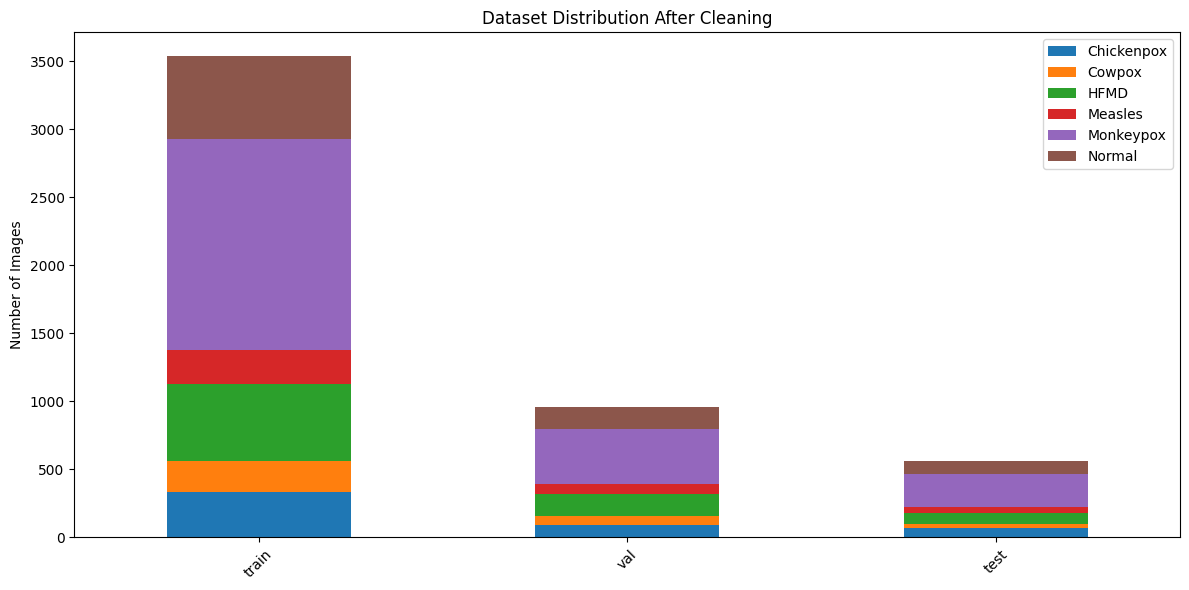

Dataset sizes - Train: 3537, Val: 957, Test: 560
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


Starting training for 30 epochs...

Epoch 1/30
------------------------------


W0919 11:40:40.477000 959 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


Batch 0/148, Loss: 1.8389
Batch 50/148, Loss: 1.6085
Batch 100/148, Loss: 1.5301
Train Loss: 1.5834, Train Acc: 34.80%
Val Loss: 1.1817, Val Acc: 57.58%
Learning Rate: 9.76e-06
New best model saved with validation accuracy: 57.58%

Epoch 2/30
------------------------------
Batch 0/148, Loss: 1.2008
Batch 50/148, Loss: 1.2458
Batch 100/148, Loss: 0.9826
Train Loss: 1.1433, Train Acc: 57.68%
Val Loss: 0.7823, Val Acc: 71.89%
Learning Rate: 9.05e-06
New best model saved with validation accuracy: 71.89%

Epoch 3/30
------------------------------
Batch 0/148, Loss: 1.1350
Batch 50/148, Loss: 1.1623
Batch 100/148, Loss: 1.0426
Train Loss: 0.9262, Train Acc: 67.46%
Val Loss: 0.5773, Val Acc: 80.67%
Learning Rate: 7.94e-06
New best model saved with validation accuracy: 80.67%

Epoch 4/30
------------------------------
Batch 0/148, Loss: 0.8798
Batch 50/148, Loss: 1.1006
Batch 100/148, Loss: 0.8190
Train Loss: 0.8433, Train Acc: 69.83%
Val Loss: 0.4677, Val Acc: 83.91%
Learning Rate: 6.55e-06
N

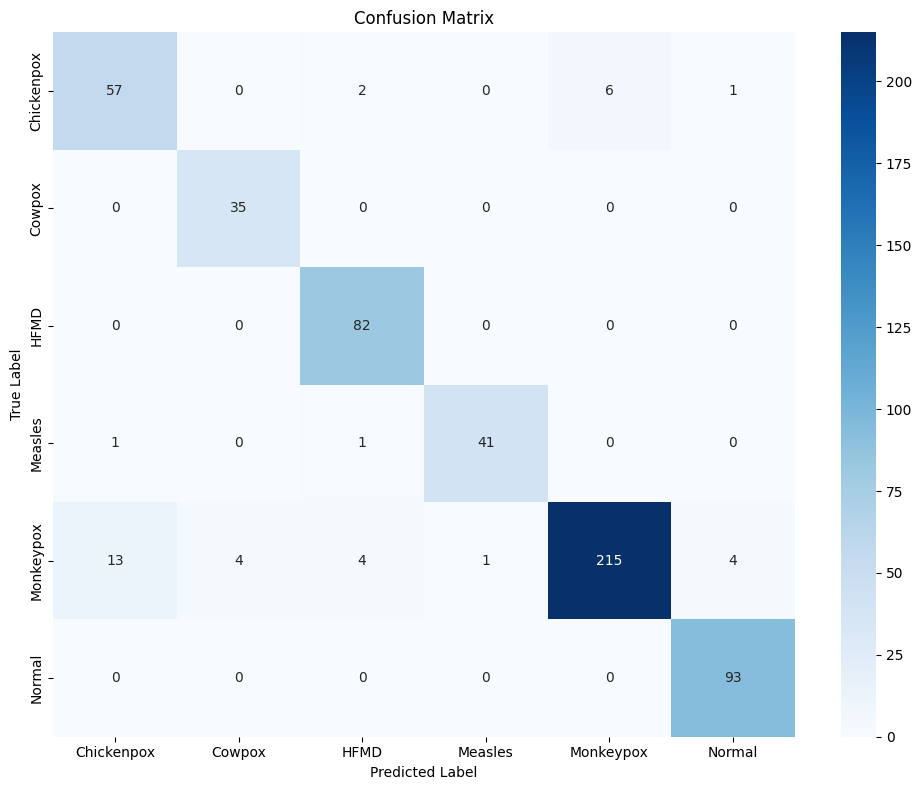

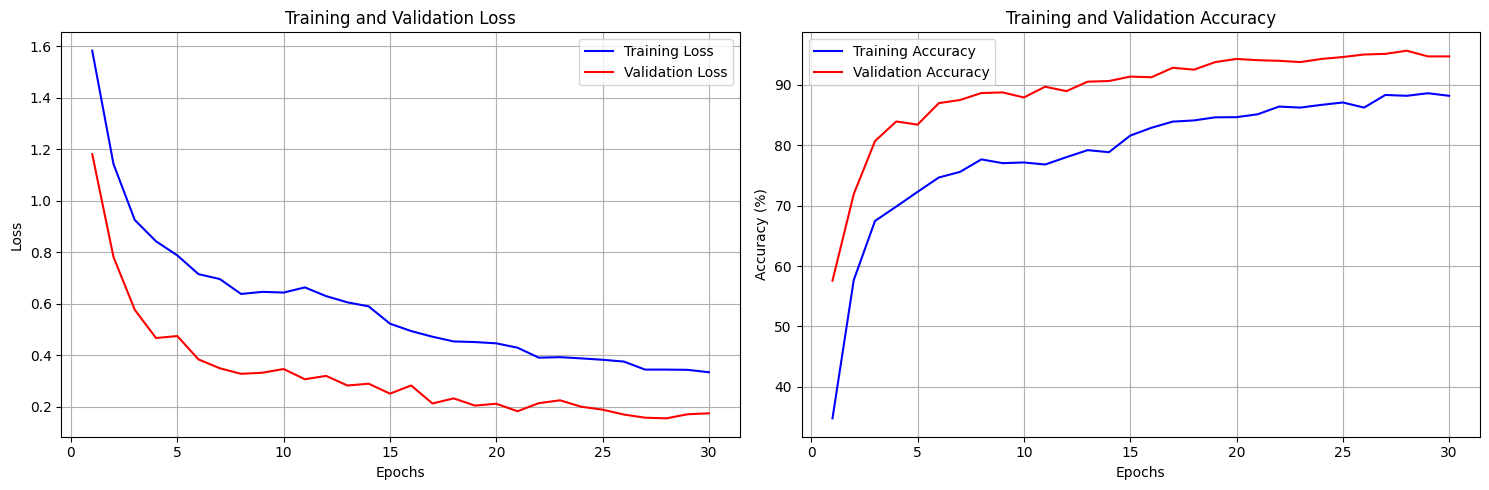


✅ Training completed successfully!
✅ Best Validation Accuracy: 95.61%
🧪 Test Accuracy: 93.39%
💾 Model saved to Google Drive for future use

🔮 Monkeypox Classification Model Ready!
🔮 To use the model later for inference, see the utility functions below


In [11]:
# Run the training
zip_path = '/content/drive/MyDrive/monkeypox_dataset.zip'  # Update to your path

if os.path.exists(zip_path):
    print("Dataset found! Starting training...")
    trainer, best_val_acc, test_acc = main(zip_path)

    if trainer is not None:
        print(f"\n✅ Training completed successfully!")
        print(f"✅ Best Validation Accuracy: {best_val_acc:.2f}%")
        print(f"🧪 Test Accuracy: {test_acc * 100:.2f}%")
        print(f"💾 Model saved to Google Drive for future use")
    else:
        print("❌ Training failed. Check the error messages above.")
else:
    print(f"❌ Dataset file not found at: {zip_path}")
    print("💡 Please make sure 'monkeypox_dataset.zip' is uploaded to your Google Drive")
    print("💡 Or update the zip_path variable to match your file location")

print("\n🔮 Monkeypox Classification Model Ready!")
print("🔮 To use the model later for inference, see the utility functions below")

## Inference Utilities (Optional)
Load saved model and predict on new images.

In [12]:
# Additional utility functions for inference
def load_model_for_inference(model_path='/content/drive/MyDrive/best_monkeypox_model.pth'):
    """Load saved model for inference"""
    checkpoint = torch.load(model_path, map_location=device)

    model = DilatedAttentionResNet(
        num_classes=checkpoint['num_classes'],
        pretrained=False
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model, checkpoint['class_names']


def predict_image(model, image_path, class_names, device=device):
    """Predict single image"""
    transform = get_validation_augmentation()

    # Load and preprocess image
    image = np.array(Image.open(image_path).convert('RGB'))
    augmented = transform(image=image)
    image_tensor = augmented['image'].unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        with autocast():
            outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    return {
        'predicted_class': class_names[predicted_class],
        'confidence': confidence,
        'all_probabilities': {class_names[i]: prob.item() for i, prob in enumerate(probabilities[0])}
    }

print("📸 Inference functions ready. Example: predict_image(model, 'path/to/image.jpg', classes)")

📸 Inference functions ready. Example: predict_image(model, 'path/to/image.jpg', classes)
